<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a>

#  Прогнозирование заказов такси

## Подготовка

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
from catboost import CatBoostRegressor

In [ ]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [ ]:
df.sort_index(inplace=True)
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Установлю колонку с датой в кач-ве индекса и преобразую ее во временной формат.

In [ ]:
print(df.index.min())
print(df.index.max())

2018-03-01 00:00:00
2018-08-31 23:50:00


Период, с которым предстоит работать, — с 1 марта по 31 августа 2018 года, т.е. полгода.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
df.isna().sum()

num_orders    0
dtype: int64

**Вывод:**
* Сделал превичную подготовку данных
* Пропусков нет, датасет чистый
* Период, с которым предстоит работать, — с 1 марта по 31 августа 2018 года, т.е. полгода.

## Анализ

По заданию нужно обучить модель для предсказания спроса на следующий час. Поэтому оценю изменения более приближенно.

In [ ]:
df = df.resample('1H').sum()

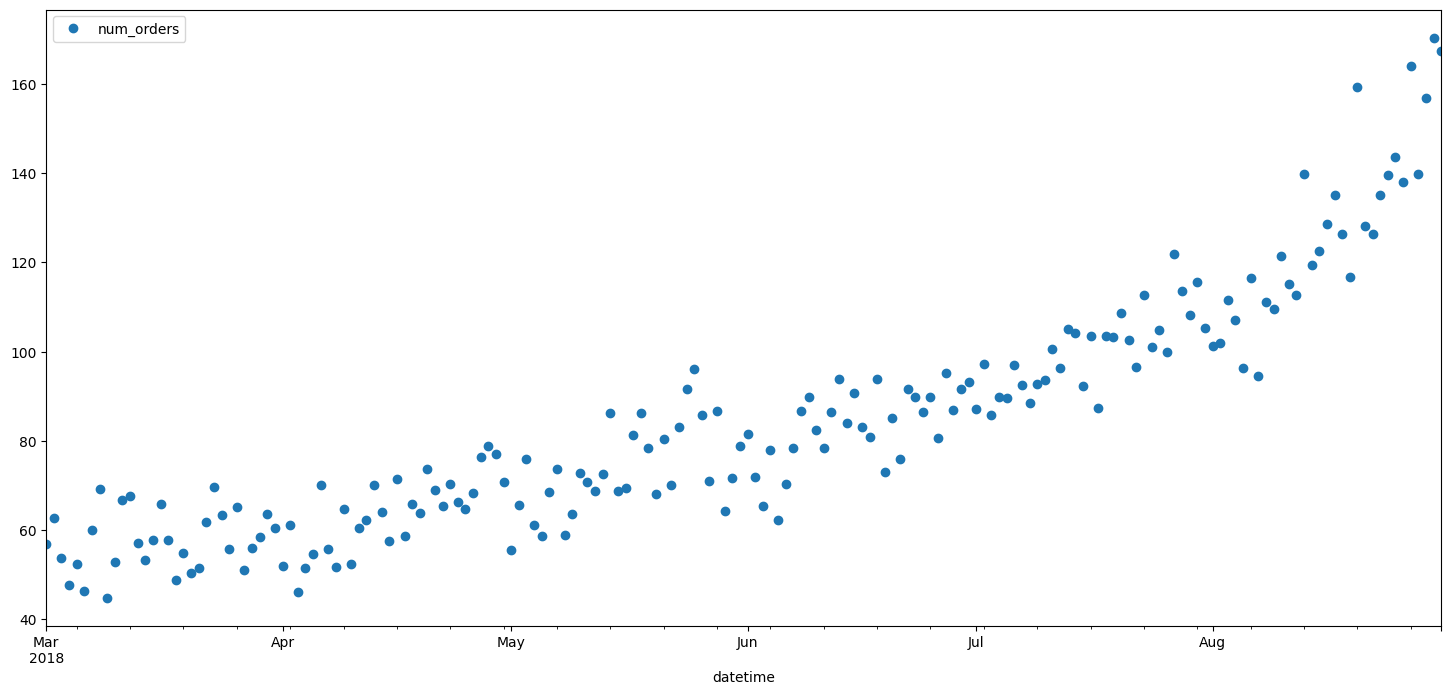

In [ ]:
df.resample('1D').mean().plot(figsize=(18,8), style='o')
plt.show()

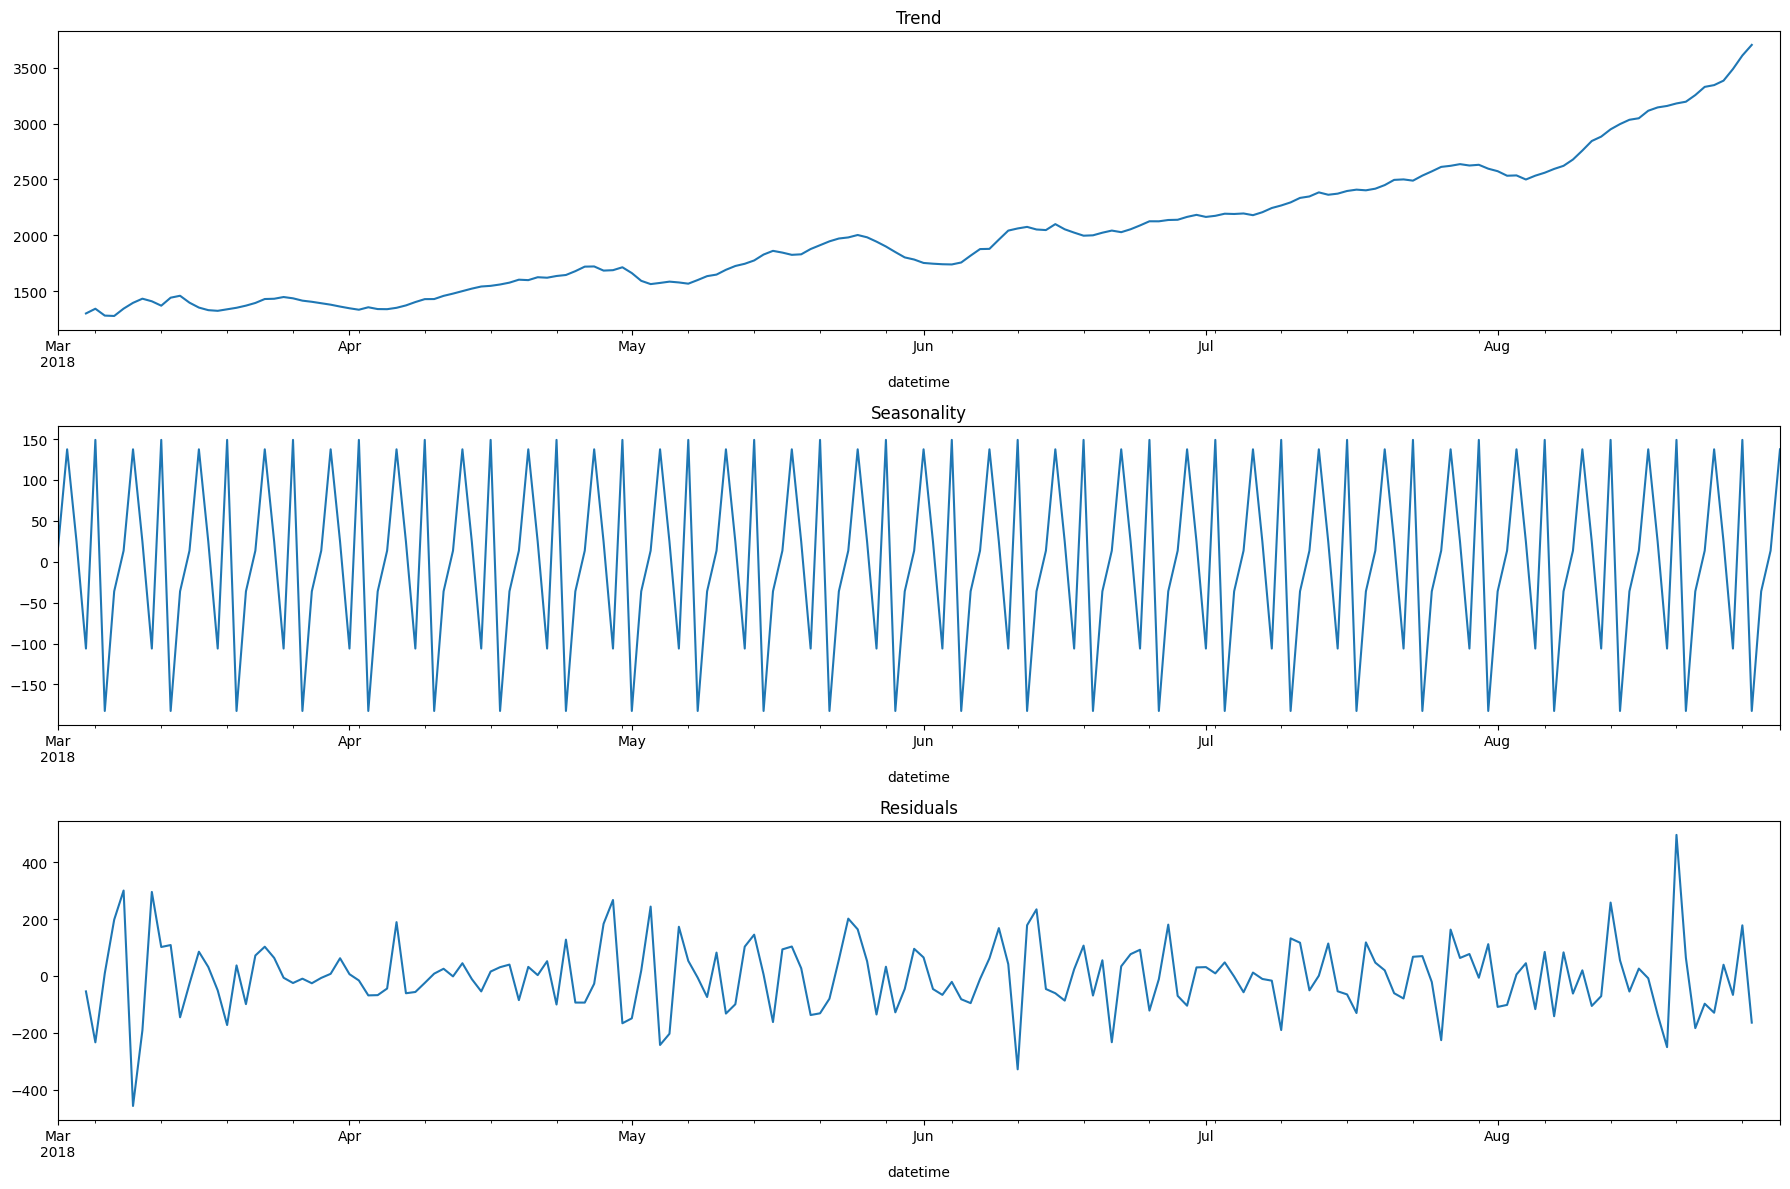

In [ ]:
data_per_day = df.resample('1D').sum()

decomposed = seasonal_decompose(data_per_day['num_orders'])

plt.figure(figsize=(18, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

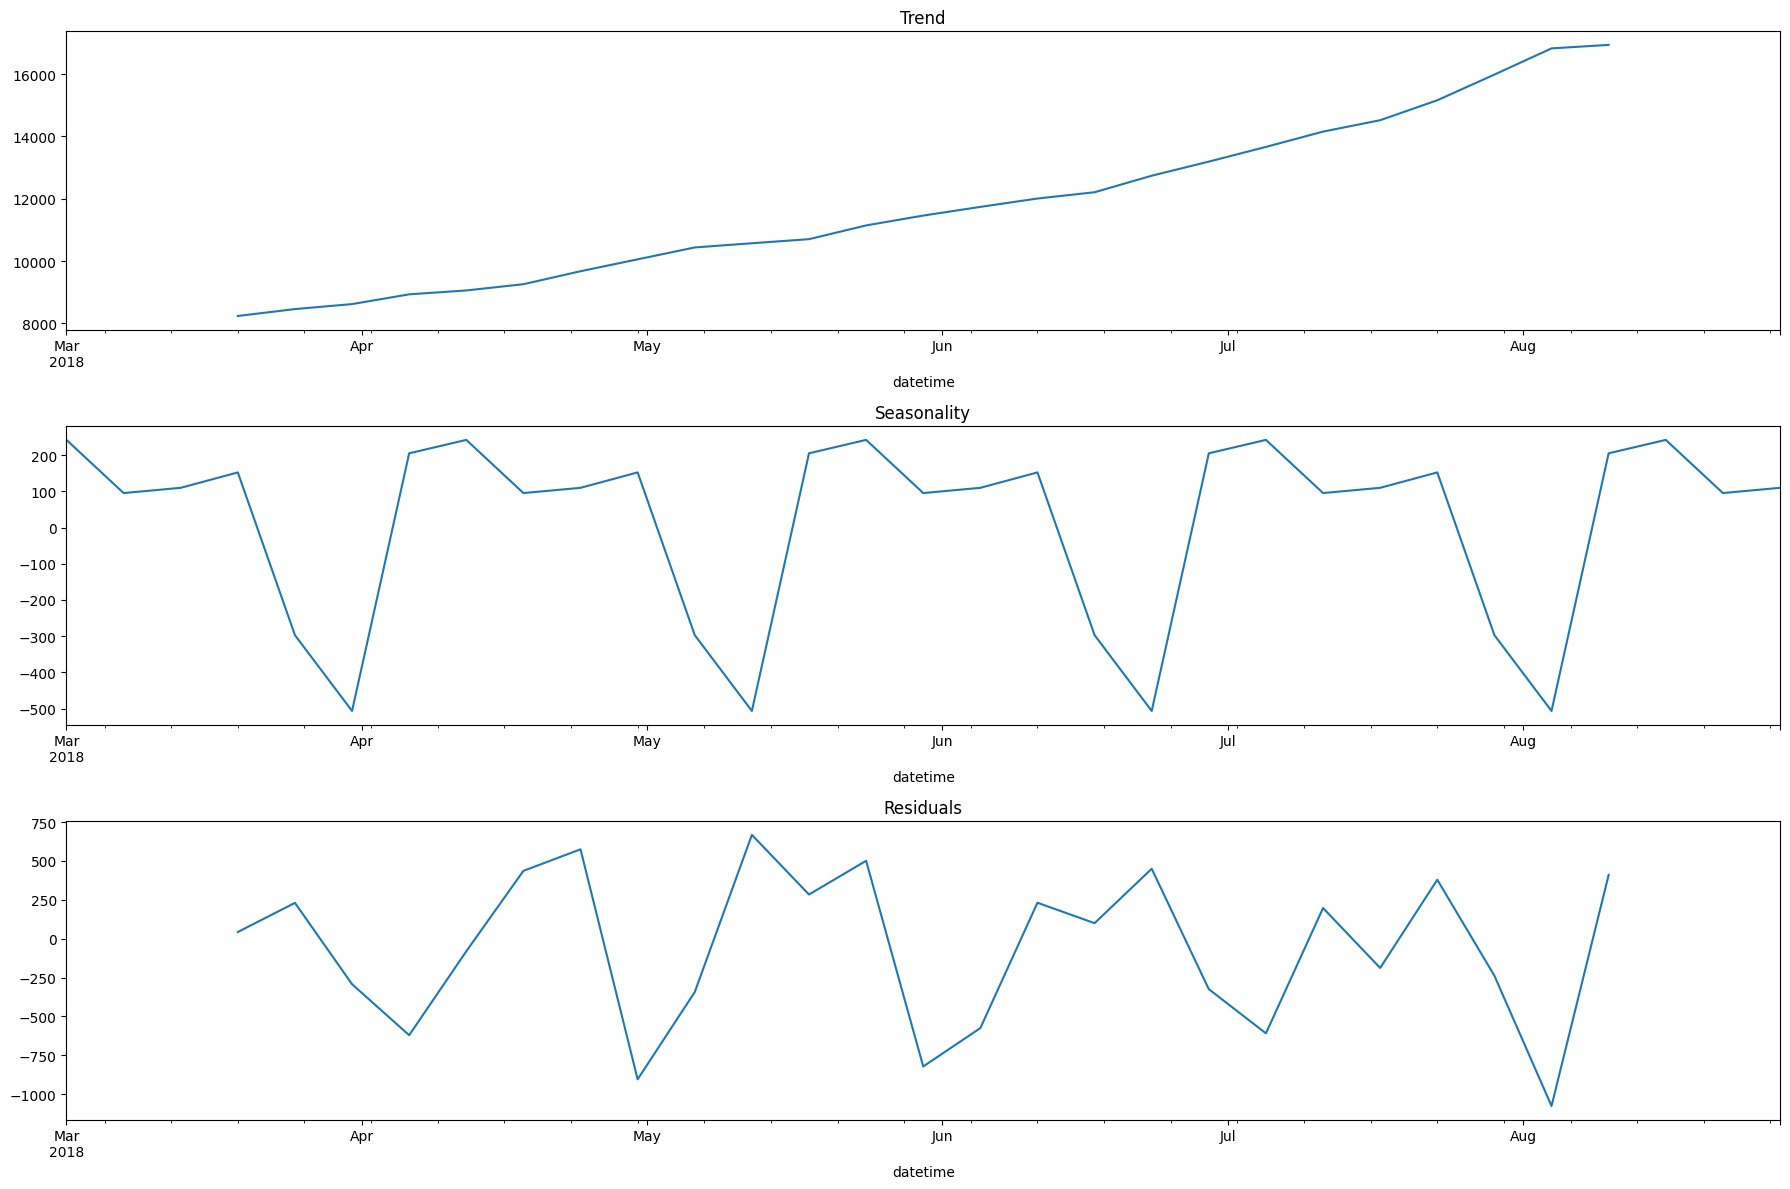

In [ ]:
data_per_week = df.resample('6D').sum()

decomposed = seasonal_decompose(data_per_week['num_orders'])

plt.figure(figsize=(18, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Построю график с сезонной составляющей (переодически повторяющейся компонентой) за один день в марте, а также в середине августа для сравнения:

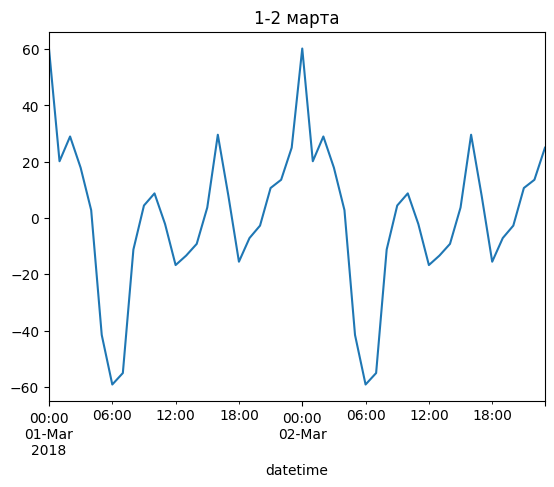

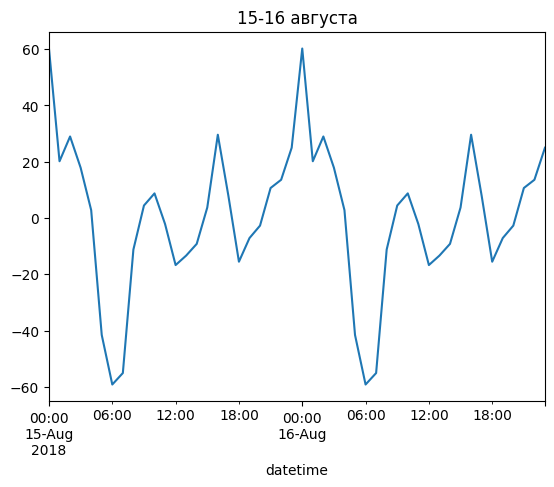

In [ ]:
decomposed = seasonal_decompose(df['num_orders'])

decomposed.seasonal['2018-03-01':'2018-03-2'].plot()
plt.title('1-2 марта')
plt.show()

decomposed.seasonal['2018-08-15':'2018-08-16'].plot()
plt.title('15-16 августа')
plt.show()

Оба графика выглядят идентичными друг другу, то есть сезонность кажется независимой от времени./

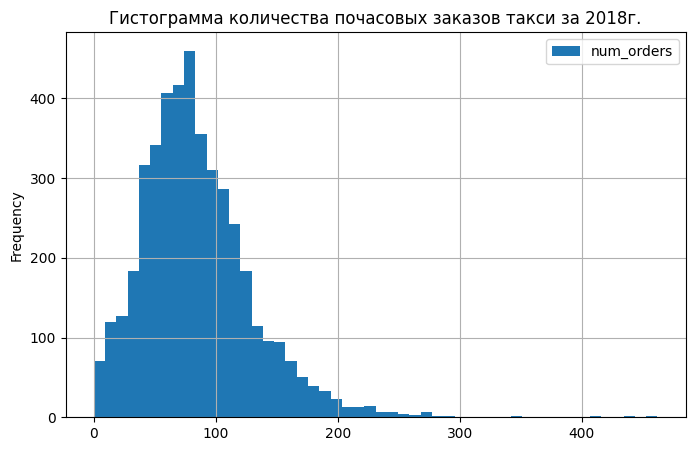

In [ ]:
df.plot(kind='hist', bins=50,figsize=(8,5),title='Гистограмма количества почасовых заказов такси за 2018г.', grid=True);

**Вывод:**
* Гистограмма принимает форму нормального распределения со сдвигом вправо, но среднее значение изменяется на графике 'Tренда' по мере приближения графика к сентябрю 2018.
* Тренд — количество заказов растет от месяца к месяцу.
* Есть посуточная сезонность — каждый день пики и спады происходят в одно и тоже время

## Обучение

In [ ]:
def make_features(data, max_lag, rolling_mean_size):

    new_df = data.copy()

    new_df['hour'] = new_df.index.hour
    new_df["weekday"] = new_df.index.weekday
    new_df['is_weekend'] = new_df.weekday.isin([5,6])*1

    for lag in range(1, max_lag + 1):
        new_df['lag_{}'.format(lag)] = new_df['num_orders'].shift(lag)

    new_df['rolling_mean'] = new_df['num_orders'].shift().rolling(rolling_mean_size).mean()

    return new_df

In [ ]:
new_df = make_features(df, 2, 24)

In [ ]:
new_df.head(5)

,num_orders,hour,weekday,is_weekend,lag_1,lag_2,rolling_mean
datetime,,,,,,,
2018-03-01 00:00:00,124,0,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,0,124.0,NaN,NaN
2018-03-01 02:00:00,71,2,3,0,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,3,0,71.0,85.0,NaN
2018-03-01 04:00:00,43,4,3,0,66.0,71.0,NaN


In [ ]:
train_valid, test = train_test_split(new_df, shuffle=False, test_size=0.1)
train_valid = train_valid.dropna()
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)

In [ ]:
X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']

X_valid = valid.drop(['num_orders'], axis=1)
y_valid = valid['num_orders']

X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

### Линейная регрессия

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
predicted_train = lr.predict(X_train)
predicted_valid = lr.predict(X_valid)

print("RMSE — ", np.sqrt(mean_squared_error(y_valid, predicted_valid)))

RMSE —  41.29163120684191


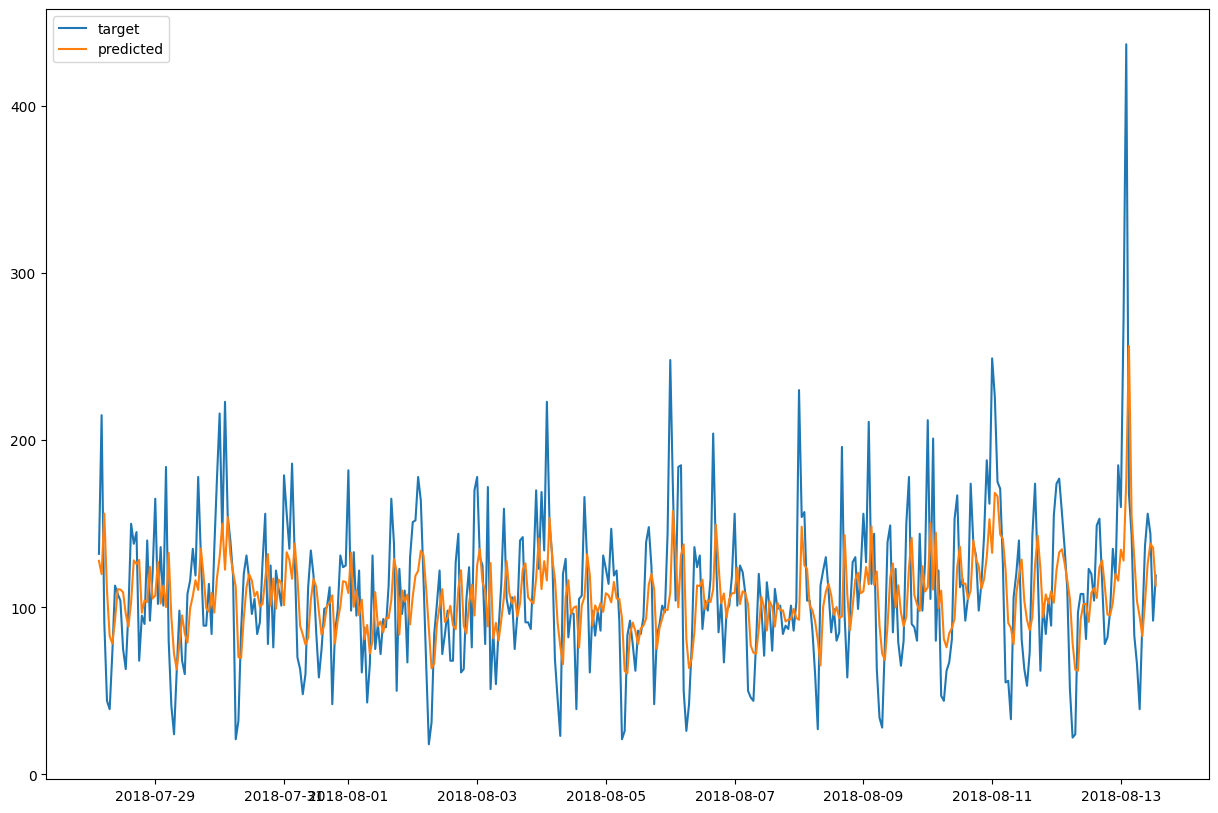

In [ ]:
a = y_valid.tolist()
b = predicted_valid.tolist()
c = y_valid.index.tolist()
plt.figure(figsize=(15, 10))
plt.plot(c, a, label = "target")
plt.plot(c, b, label = "predicted")
plt.legend()
plt.show()

### Случайный лес

In [ ]:
parameters={"max_depth" : [None] + [i for i in range(2, 11)],
           'n_estimators': [25,50,100,150]}

regr = RandomForestRegressor(random_state=666, max_features=4)

tuning_model_rfr = GridSearchCV(
    regr,
    param_grid=parameters,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

In [ ]:
tuning_model_rfr.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


GridSearchCV(cv=3,
             estimator=RandomForestRegressor(max_features=4, random_state=666),
             n_jobs=-1,
             param_grid={'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [25, 50, 100, 150]},
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
tuning_model_rfr.best_params_

{'max_depth': None, 'n_estimators': 150}

In [ ]:
model = RandomForestRegressor(random_state=666,
                              max_features=4,
                              max_depth=None,
                              n_estimators=150,
                              verbose=1, n_jobs=-1)
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.2s finished


RandomForestRegressor(max_features=4, n_estimators=150, n_jobs=-1,
                      random_state=666, verbose=1)

In [ ]:
y_pred_rfr = tuning_model_rfr.predict(X_valid)
print(f'RMSE = {np.sqrt(mean_squared_error(y_valid, y_pred_rfr))}')

RMSE = 31.8527464697357


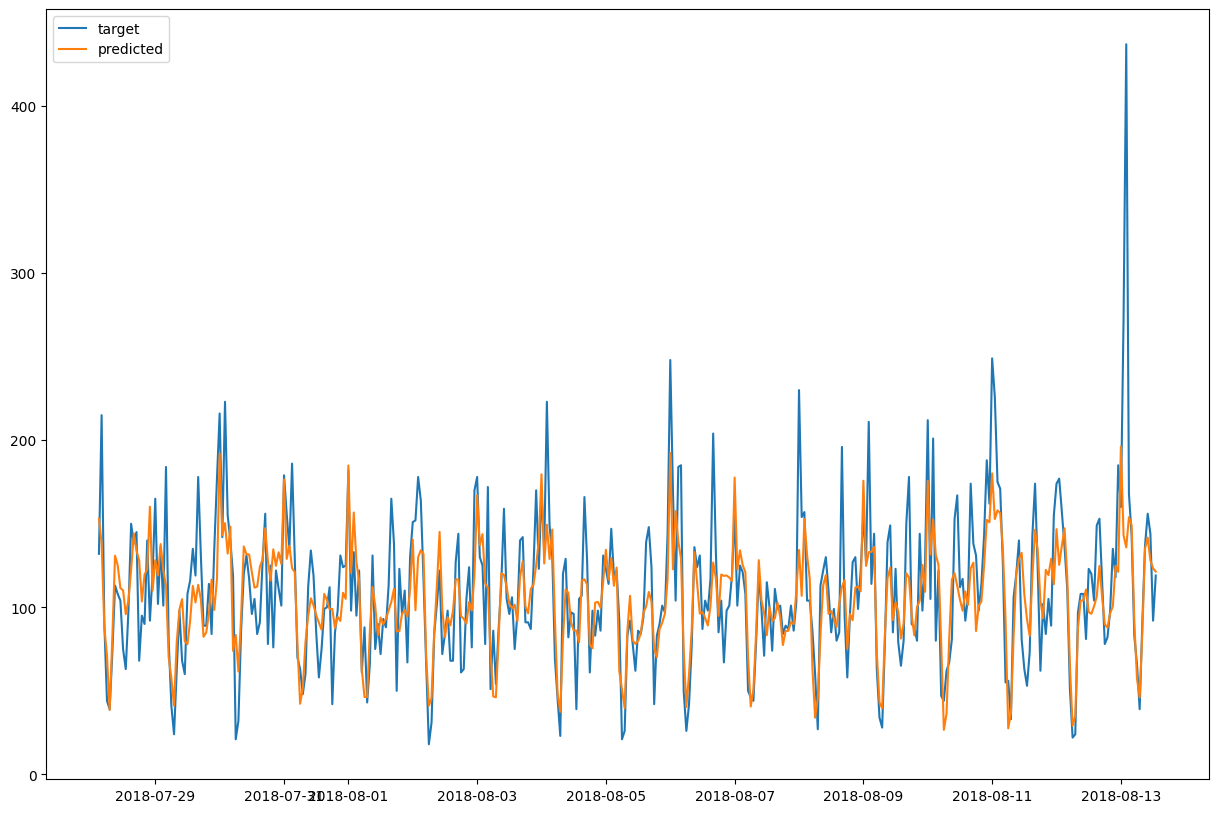

In [ ]:
a = y_valid.tolist()
b = y_pred_rfr.tolist()
c = y_valid.index.tolist()
plt.figure(figsize=(15, 10))
plt.plot(c, a, label = "target")
plt.plot(c, b, label = "predicted")
plt.legend()
plt.show()

### Catboost

In [ ]:
parameters =  {'depth': [6, 8],
               'l2_leaf_reg': [1, 3],
                'metric_period': [100]}

cbr = CatBoostRegressor(random_state=666, iterations=1000)
tuning_model_cbr = GridSearchCV(
    cbr,
    param_grid=parameters,
    cv=3,
    #verbose=0,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
)
tuning_model_cbr.fit(X_train, y_train)

0:	learn: 35.6258313	total: 1.88ms	remaining: 1.88s
100:	learn: 22.8795581	total: 150ms	remaining: 1.34s
200:	learn: 21.0339402	total: 293ms	remaining: 1.17s
300:	learn: 19.9324795	total: 432ms	remaining: 1s
400:	learn: 19.1496607	total: 591ms	remaining: 884ms
500:	learn: 18.5329931	total: 733ms	remaining: 730ms
600:	learn: 18.0071389	total: 882ms	remaining: 585ms
700:	learn: 17.4930902	total: 1.02s	remaining: 434ms
800:	learn: 17.0836701	total: 1.17s	remaining: 290ms
900:	learn: 16.7363041	total: 1.3s	remaining: 143ms
999:	learn: 16.4003347	total: 1.45s	remaining: 0us


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f08a190f580>,
             n_jobs=-1,
             param_grid={'depth': [6, 8], 'l2_leaf_reg': [1, 3],
                         'metric_period': [100]},
             scoring='neg_mean_squared_error')

In [ ]:
tuning_model_cbr.best_params_

{'depth': 6, 'l2_leaf_reg': 3, 'metric_period': 100}

In [ ]:
model = CatBoostRegressor(random_state=666,
                          depth=6,
                          iterations=1000,
                          l2_leaf_reg=3,
                          learning_rate=.1,
                          metric_period=100)
model.fit(X_train, y_train)

0:	learn: 34.5130263	total: 3.38ms	remaining: 3.38s
100:	learn: 19.7250144	total: 228ms	remaining: 2.03s
200:	learn: 17.7333471	total: 572ms	remaining: 2.27s
300:	learn: 16.4280471	total: 794ms	remaining: 1.84s
400:	learn: 15.4155094	total: 984ms	remaining: 1.47s
500:	learn: 14.6407019	total: 1.21s	remaining: 1.21s
600:	learn: 13.8929174	total: 1.44s	remaining: 957ms
700:	learn: 13.2770993	total: 1.69s	remaining: 720ms
800:	learn: 12.7132983	total: 1.88s	remaining: 467ms
900:	learn: 12.1380545	total: 2.12s	remaining: 233ms
999:	learn: 11.6715618	total: 2.35s	remaining: 0us


In [ ]:
y_pred_cbr = model.predict(X_valid)
print(f'RMSE = {np.sqrt(mean_squared_error(y_valid, y_pred_cbr))}')

RMSE = 30.980382677183908


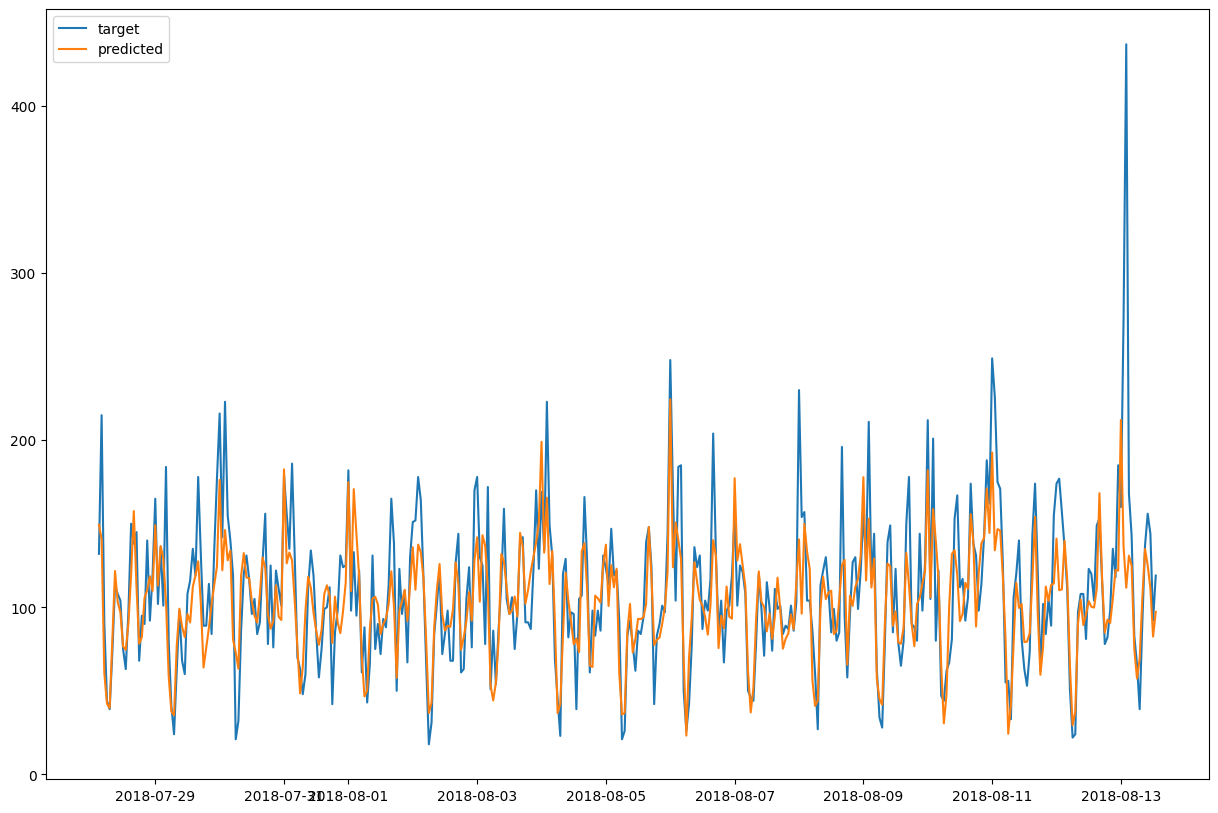

In [ ]:
a = y_valid.tolist()
b = y_pred_cbr.tolist()
c = y_valid.index.tolist()
plt.figure(figsize=(15, 10))
plt.plot(c, a, label = "target")
plt.plot(c, b, label = "predicted")
plt.legend()
plt.show()

### LightGBM

In [ ]:
params = {
    'max_depth': [None] + [i for i in range(2, 11)],
    'n_estimators': [25,50,100],
}

lgbmr = lgb.LGBMRegressor(random_state=666, learning_rate=.1)

tuning_model_lgbmr = GridSearchCV(
    lgbmr,
    param_grid=params,
    cv=3,
    verbose=2,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

tuning_model_lgbmr.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=666), n_jobs=-1,
             param_grid={'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [25, 50, 100]},
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
tuning_model_lgbmr.best_params_

{'max_depth': 4, 'n_estimators': 100}

In [ ]:
lgbmr = lgb.LGBMRegressor(random_state=666, learning_rate=.1,
                     max_depth=4, n_estimators=100)
lgbmr.fit(X_train, y_train)

LGBMRegressor(max_depth=4, random_state=666)

In [ ]:
y_pred_lgbmr = lgbmr.predict(X_valid)
print(f'RMSE = {np.sqrt(mean_squared_error(y_valid, y_pred_lgbmr))}')

RMSE = 31.273975032024648


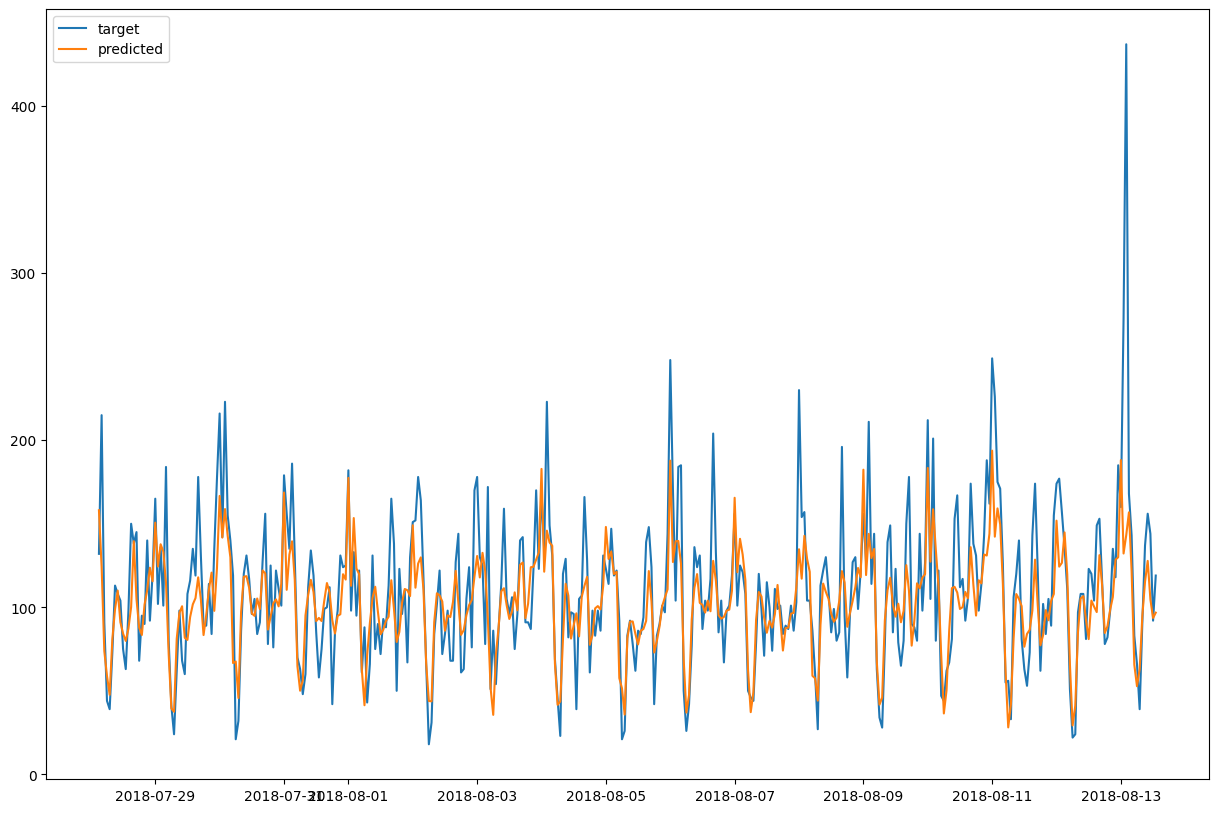

In [ ]:
a = y_valid.tolist()
b = y_pred_lgbmr.tolist()
c = y_valid.index.tolist()
plt.figure(figsize=(15, 10))
plt.plot(c, a, label = "target")
plt.plot(c, b, label = "predicted")
plt.legend()
plt.show()

**Вывод:**

Лучший результат получил на Catboost. RMSE — 30.37 на валидационной выборке.

## Тестирование

In [ ]:
model = CatBoostRegressor(random_state=666,
                          depth=6,
                          iterations=1000,
                          l2_leaf_reg=3,
                          learning_rate=.1,
                          metric_period=100)
model.fit(X_valid, y_valid)

0:	learn: 44.8745500	total: 1.83ms	remaining: 1.83s
100:	learn: 20.0024866	total: 565ms	remaining: 5.03s
200:	learn: 14.1589162	total: 936ms	remaining: 3.72s
300:	learn: 10.0330222	total: 1.42s	remaining: 3.3s
400:	learn: 7.7626699	total: 1.79s	remaining: 2.68s
500:	learn: 5.9826931	total: 2.3s	remaining: 2.29s
600:	learn: 4.8236823	total: 2.83s	remaining: 1.88s
700:	learn: 3.7722141	total: 3.22s	remaining: 1.37s
800:	learn: 2.9897291	total: 3.63s	remaining: 903ms
900:	learn: 2.3839932	total: 4.11s	remaining: 451ms
999:	learn: 1.9226801	total: 4.52s	remaining: 0us


In [ ]:
final_model = model.predict(X_test)
print(f'RMSE = {np.sqrt(mean_squared_error(y_test, final_model))}')

RMSE = 45.98031285378452


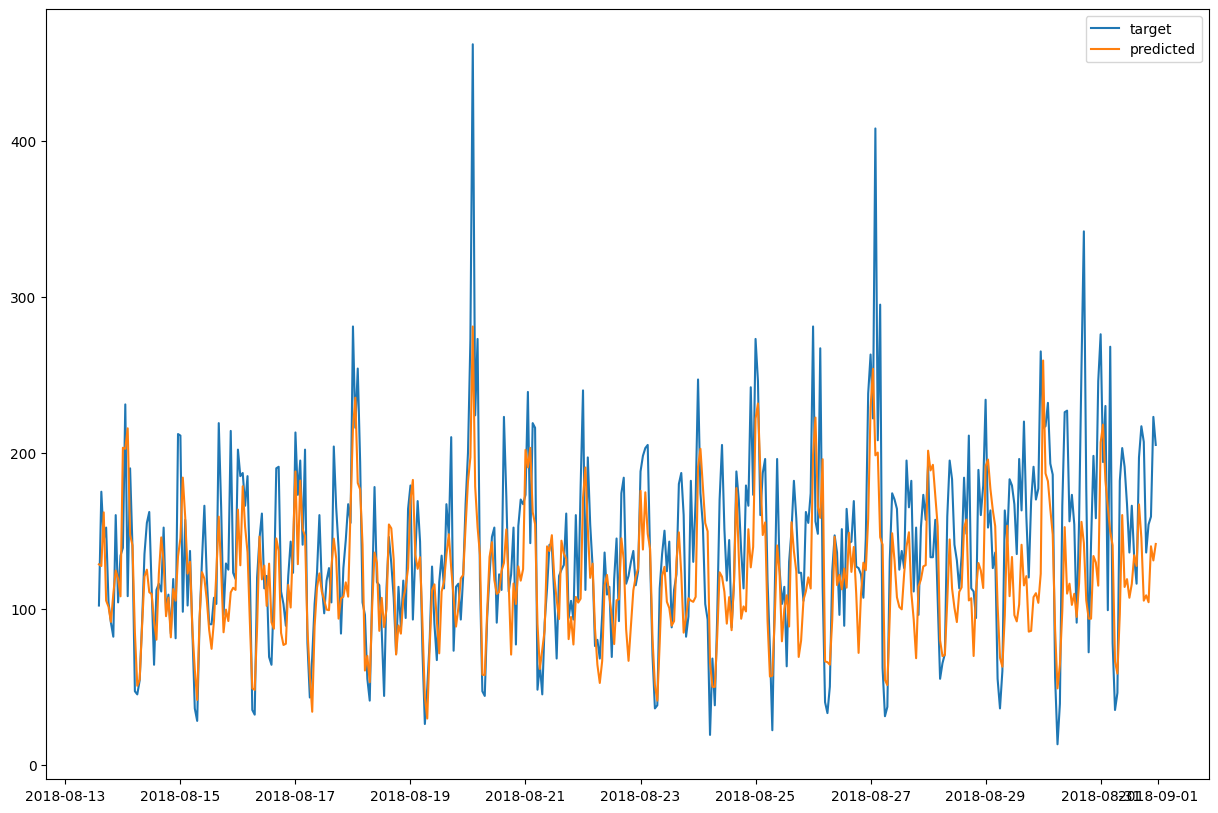

In [ ]:
a = y_test.tolist()
b = final_model.tolist()
c = y_test.index.tolist()
plt.figure(figsize=(15, 10))
plt.plot(c, a, label = "target")
plt.plot(c, b, label = "predicted")
plt.legend()
plt.show()

**Вывод:**
Я подобрал и построил модель для прогнозирования количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки. Catbost - модель с наилучшим RMSE, равным 45.5 на тестовой выборке и 34.66 на валидационной. Цель загаза достигнута RMSE <= 48.